In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from models import NNODEModel, NeuralNetODEModel, FullyLinearLayerModel
from utiils import train_model, test_model, train_test_split, create_matrix_time, input_target_split

# The dataset to fit

## Stock market

In [54]:
data_path = '../data/'
data = pd.read_parquet(data_path+'SPY_hourly.parquet')

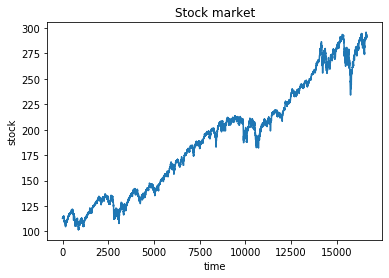

In [56]:
plt.plot(data.values)
plt.title('Stock market')
plt.xlabel('time')
plt.ylabel('stock')
plt.savefig('../figure/stock/stock.png')
plt.show()

In [59]:
price = data.values
price.shape

(16649, 1)

In [115]:
price_centered = price - price.mean()
price_stand = price_centered/price.std()

In [63]:
train_set, test_set = train_test_split(price_stand)

In [64]:
train_set_mis = train_set[:-5]
test_set_mis = test_set[:-6]

In [65]:
print('size')
print('training: ', train_set_mis.shape)
print('test:', test_set_mis.shape)

size
training:  (13314, 1)
test: (3324, 1)


## Difference market

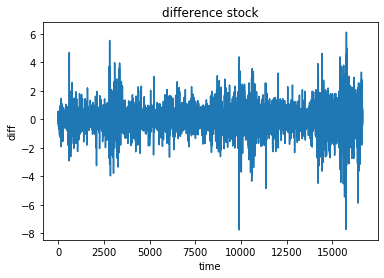

In [60]:
diff = []
for t in range(1,len(price)):
    value = price[t] - price[t-1]
    diff.append(value)
    
diff = np.array(diff)
plt.plot(diff)
plt.title('difference stock')
plt.ylabel('diff')
plt.xlabel('time')
plt.savefig('../figure/diff/diff.png')
plt.show()

In [62]:
diff_centered = diff - diff.mean()
diff_stand = diff_centered/diff.std()

## z-component Lorenz attractor

In [66]:
x = 0
y = 1
z = 1.05
sigma = 10
rho = 30
beta = 8/3
dt = 0.01
T = 10000 - 1
sol = [[x, y, z]]

A = np.asarray([[-sigma, sigma, 0], [rho, -1, 0], [0, 0, -beta]])
Q0 = np.asarray([[0,0,0], [0,0,0], [0,0,0]])*dt
Q1= np.asarray([[0,0,-1], [0,0,0], [0,0,0]])*dt
Q2 = np.asarray([[0,1,0],[0,0,0], [0,0,0]])*dt

B = np.array([Q0, Q1, Q2])
dim = 3
I = np.eye(dim)
AA = (I+dt*A)

for i in range(T):
    x = np.asarray(sol[-1])
    Ax = AA.dot(x)

    phix = x.T.dot(B).dot(x)

    f = Ax + phix
    sol.append(f)
    
z_lorenz = np.array([lorenz[:,2]]).transpose()
z_lorenz.shape

(10000, 1)

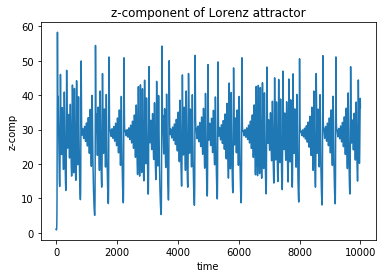

In [67]:
plt.plot(z_lorenz)
plt.title('z-component of Lorenz attractor')
plt.xlabel('time')
plt.ylabel('z-comp')
plt.savefig('../figure/z_lorenz/z_lorenz.png')
plt.show()

## Fit the model

## Stock market

In [76]:
price_centered = price - price.mean()
price_stand = price_centered/price.std()
train_set, test_set = train_test_split(price_stand)

In [77]:
print('size')
print('training: ', train_set.shape)
print('test:', test_set.shape)

size
training:  (13319, 1)
test: (3330, 1)


In [78]:
train_set_mis = train_set[:-5]
test_set_mis = test_set[:-6]

In [79]:
print('size')
print('training: ', train_set_mis.shape)
print('test:', test_set_mis.shape)

size
training:  (13314, 1)
test: (3324, 1)


In [80]:
N = 10
delta = 5
train_x, train_y = input_target_split(train_set_mis, delta, N)
test_x, test_y = input_target_split(test_set_mis, delta, N)
print('train input size: ', train_x.shape)
print('train target size: ', train_y.shape)
print('test input size: ', test_x.shape)
print('train input size: ', test_y.shape)

train input size:  torch.Size([13300, 10])
train target size:  torch.Size([13300, 10])
test input size:  torch.Size([3310, 10])
train input size:  torch.Size([3310, 10])


### ODE layer

In [81]:
in_dim = 10
out_dim = 10
hid_dim = 3
model_ode = NeuralNetODEModel(input_dim=in_dim, hidden_dim=hid_dim, output_dim=out_dim)
optim_ode = optim.Adagrad(model_ode.parameters(), lr=1e-2)

In [82]:
print('Start training ODE model')
run_session(model_ode, optim_ode, train_x, train_y, test_x, test_y)
print('End training')

Start training ODE model
Epoch: 1 , train_loss: 118.2860710346431 , test_loss: 76.97505686432123
Epoch: 11 , train_loss: 0.5218693279348372 , test_loss: 0.24156151305032836
Epoch: 21 , train_loss: 0.5037231255482766 , test_loss: 0.2355159912531235
Epoch: 31 , train_loss: 0.49282048656959887 , test_loss: 0.23609640294580458
Epoch: 41 , train_loss: 0.48394889676092134 , test_loss: 0.23649903934347094
Epoch: 51 , train_loss: 0.4763492507427145 , test_loss: 0.23677151593710732
Epoch: 61 , train_loss: 0.469644670715752 , test_loss: 0.23695039528411144
Epoch: 71 , train_loss: 0.4636139535837174 , test_loss: 0.23706041271543654
Epoch: 81 , train_loss: 0.4581141068033503 , test_loss: 0.23711358871423727
Epoch: 91 , train_loss: 0.45304607385105555 , test_loss: 0.23712008145048458
Epoch: 101 , train_loss: 0.4483382690559665 , test_loss: 0.23708485179849959
Epoch: 111 , train_loss: 0.44393702772777033 , test_loss: 0.23701926888861635
Epoch: 121 , train_loss: 0.4398005700822978 , test_loss: 0.2369

### FC layer

In [86]:
in_dim = 10
out_dim = 10
hid_dim = 3
model_fc = FullyLinearLayerModel(input_dim=in_dim, hidden_dim=hid_dim, output_dim=out_dim)
optim_fc = optim.Adagrad(model_fc.parameters(), lr=1e-2)

In [87]:
print('Start training FC model')
run_session(model_fc, optim_fc, train_x, train_y, test_x, test_y)
print('End training')

Start training FC model
Epoch: 1 , train_loss: 171.6706469184719 , test_loss: 41.446328438818455
Epoch: 11 , train_loss: 0.6370490219860585 , test_loss: 0.4358136587543413
Epoch: 21 , train_loss: 0.6165755396764325 , test_loss: 0.42213393367455865
Epoch: 31 , train_loss: 0.5999844617344934 , test_loss: 0.41114369933529815
Epoch: 41 , train_loss: 0.5857386368802509 , test_loss: 0.40165199906005
Epoch: 51 , train_loss: 0.5732241233795321 , test_loss: 0.3932795754080871
Epoch: 61 , train_loss: 0.5620474384031695 , test_loss: 0.38577915212499647
Epoch: 71 , train_loss: 0.5519379492056942 , test_loss: 0.37897928074744414
Epoch: 81 , train_loss: 0.5427035152074495 , test_loss: 0.37275729171688
Epoch: 91 , train_loss: 0.5341992364524231 , test_loss: 0.3670190805269158
Epoch: 101 , train_loss: 0.5263152156016986 , test_loss: 0.36169309250544757
Epoch: 111 , train_loss: 0.5189650093716409 , test_loss: 0.3567229026120913
Epoch: 121 , train_loss: 0.5120794367780945 , test_loss: 0.352063264467688


### Models comparison

In [88]:
prediction_ode = model_ode(test_x)
prediction_fc = model_fc(test_x)
diff_ode = prediction_ode.detach() - test_y
diff_fc = prediction_fc.detach() - test_y

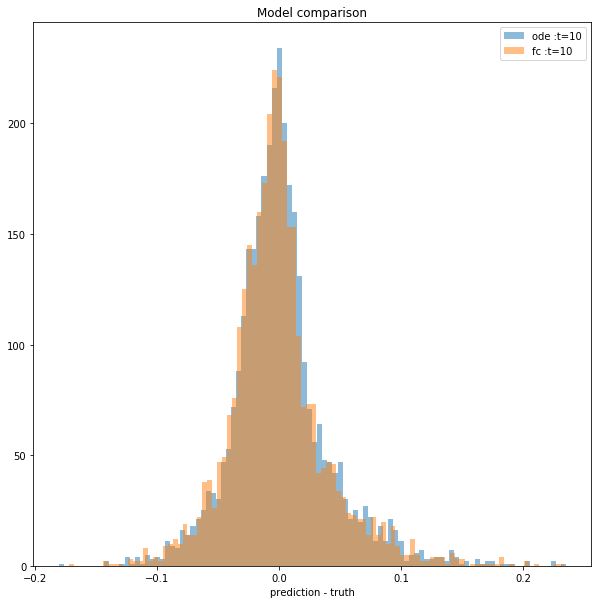

In [91]:
plt.figure(figsize=(10,10))
plt.hist(diff_ode[:,9], label='ode :t=10', alpha = 0.5, bins = 100);
plt.hist(diff_fc[:,9], label='fc :t=10', alpha = 0.5, bins = 100)
plt.title('Model comparison')
plt.xlabel('prediction - truth')
plt.legend()
plt.savefig('../figure/stock/stock_hist.png')
plt.show()

## Model with stationary time series: difference stock market

In [131]:
diff = []
for t in range(1,len(price_stand)):
    value = price_stand[t] - price_stand[t-1]
    diff.append(value)
    
diff = np.array(diff)
train_set, test_set = train_test_split(diff_stand)

In [132]:
train_set.shape

(13318, 1)

In [133]:
test_set.shape

(3330, 1)

In [134]:
train_set_mis = train_set[:-4]
test_set_mis = test_set[:-6]

In [135]:
delta = 5
N = 10
train_x, train_y = input_target_split(train_set_mis, delta, N)
test_x, test_y = input_target_split(test_set_mis, delta, N)
print('train input size: ', train_x.shape)
print('train target size: ', train_y.shape)
print('test input size: ', test_x.shape)
print('train input size: ', test_y.shape)

train input size:  torch.Size([13300, 10])
train target size:  torch.Size([13300, 10])
test input size:  torch.Size([3310, 10])
train input size:  torch.Size([3310, 10])


### ODE layer

In [119]:
in_dim = 10
out_dim = 10
hid_dim = 3
model_ode = NeuralNetODEModel(input_dim=in_dim, hidden_dim=hid_dim, output_dim=out_dim)
optim_ode = optim.Adagrad(model_ode.parameters(), lr=1e-2)

In [120]:
print('Start training ODE model')
run_session(model_ode, optim_ode, train_x, train_y, test_x, test_y)
print('End training')

Start training ODE model
Epoch: 1 , train_loss: 927.2299392968416 , test_loss: 608.2913839630783
Epoch: 11 , train_loss: 789.3504735380411 , test_loss: 538.6143211983144
Epoch: 21 , train_loss: 705.1106343809515 , test_loss: 477.565665833652
Epoch: 31 , train_loss: 694.5599927287549 , test_loss: 468.1337863653898
Epoch: 41 , train_loss: 693.4839156232774 , test_loss: 467.08145966008306
Epoch: 51 , train_loss: 693.2815393619239 , test_loss: 466.8586228489876
Epoch: 61 , train_loss: 693.221927665174 , test_loss: 466.7879353091121
Epoch: 71 , train_loss: 693.1960967350751 , test_loss: 466.75799771398306
Epoch: 81 , train_loss: 693.1808286998421 , test_loss: 466.74232184141874
Epoch: 91 , train_loss: 693.1697430741042 , test_loss: 466.7327941134572
Epoch: 101 , train_loss: 693.1606686208397 , test_loss: 466.7263620123267
Epoch: 111 , train_loss: 693.1527449022979 , test_loss: 466.7216851487756
Epoch: 121 , train_loss: 693.1455643065274 , test_loss: 466.718103826046
Epoch: 131 , train_loss:

### FC layer

In [136]:
in_dim = 10
out_dim = 10
hid_dim = 3
model_fc = FullyLinearLayerModel(input_dim=in_dim, hidden_dim=hid_dim, output_dim=out_dim)
optim_fc = optim.Adagrad(model_fc.parameters(), lr=1e-2)

In [137]:
print('Start training ODE model')
run_session(model_fc, optim_fc, train_x, train_y, test_x, test_y)
print('End training')

Start training ODE model
Epoch: 1 , train_loss: 871.2540345806628 , test_loss: 550.493861336261
Epoch: 11 , train_loss: 701.1374397948384 , test_loss: 476.5387941673398
Epoch: 21 , train_loss: 695.5405562315136 , test_loss: 473.15859255567193
Epoch: 31 , train_loss: 694.4845002349466 , test_loss: 472.47399177774787
Epoch: 41 , train_loss: 694.1585142537951 , test_loss: 472.24910067394376
Epoch: 51 , train_loss: 694.0280897524208 , test_loss: 472.15216844156384
Epoch: 61 , train_loss: 693.9650460481644 , test_loss: 472.10100949928164
Epoch: 71 , train_loss: 693.9292626194656 , test_loss: 472.0691906027496
Epoch: 81 , train_loss: 693.9058914016932 , test_loss: 472.04660783335567
Epoch: 91 , train_loss: 693.8887530006468 , test_loss: 472.0289484448731
Epoch: 101 , train_loss: 693.8750229757279 , test_loss: 472.01413714140654
Epoch: 111 , train_loss: 693.8633179944009 , test_loss: 472.0011324211955
Epoch: 121 , train_loss: 693.8529068548232 , test_loss: 471.98934511095285
Epoch: 131 , trai

### Models comparison

In [138]:
prediction_ode = model_ode(test_x)
prediction_fc = model_fc(test_x)

In [139]:
diff_ode = prediction_ode.detach() - test_y
diff_fc = prediction_fc.detach() - test_y

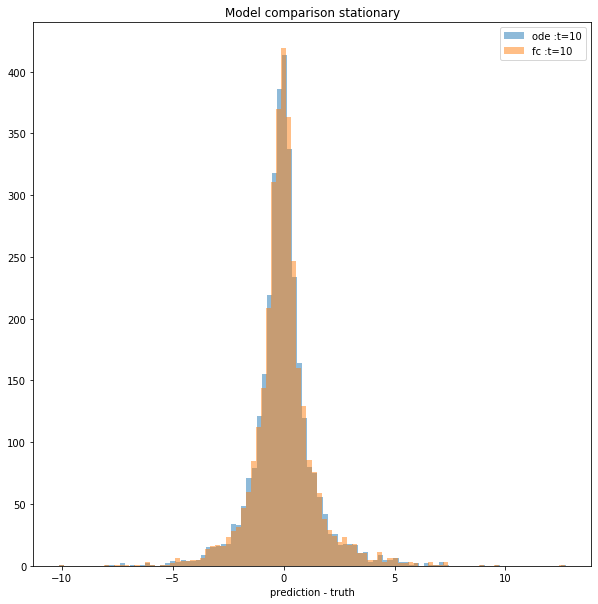

In [140]:
plt.figure(figsize=(10,10))
plt.hist(diff_ode[:,9], label='ode :t=10', alpha = 0.5, bins = 100);
plt.hist(diff_fc[:,9], label='fc :t=10', alpha = 0.5, bins = 100)
plt.title('Model comparison stationary')
plt.xlabel('prediction - truth')
plt.savefig('../figure/diff/diff_hist.png')
plt.legend()
plt.show()

# Lorenz attractor

In [141]:
z_lorenz_centered = z_lorenz - z_lorenz.mean()
z_lorenz_stand = z_lorenz_centered/z_lorenz.std()

In [142]:
train_set, test_set = train_test_split(z_lorenz_stand)

In [143]:
print('train size: ',train_set.shape)
print('test size: ',test_set.shape)

train size:  (8000, 1)
test size:  (2000, 1)


In [144]:
train_set_mis = train_set[:-6]
test_set_mis = test_set[:-6]
print('train size: ',train_set_mis.shape)
print('test size: ',test_set_mis.shape)

train size:  (7994, 1)
test size:  (1994, 1)


In [145]:
N = 10
delta = 5
train_x, train_y = input_target_split(train_set_mis, delta, N)
test_x, test_y = input_target_split(test_set_mis, delta, N)
print('train input size: ', train_x.shape)
print('train target size: ', train_y.shape)
print('test input size: ', test_x.shape)
print('train input size: ', test_y.shape)

train input size:  torch.Size([7980, 10])
train target size:  torch.Size([7980, 10])
test input size:  torch.Size([1980, 10])
train input size:  torch.Size([1980, 10])


In [146]:
in_dim = 10
out_dim = 10
hid_dim = 3
model_ode = NeuralNetODEModel(input_dim=in_dim, hidden_dim=hid_dim, output_dim=out_dim)
model_fc = FullyLinearLayerModel(input_dim=in_dim, hidden_dim=hid_dim, output_dim=out_dim)

optim_ode = optim.Adagrad(model_ode.parameters(), lr=1e-2)
optim_fc = optim.Adagrad(model_fc.parameters(), lr=1e-2)

### ODE Layer

In [147]:
print('Start training ODE model')
run_session(model_ode, optim_ode, train_x, train_y, test_x, test_y)
print('End training')

Start training ODE model
Epoch: 1 , train_loss: 569.6741793248802 , test_loss: 59.68597666826099
Epoch: 11 , train_loss: 65.18077674193773 , test_loss: 11.48849734995747
Epoch: 21 , train_loss: 62.814143483294174 , test_loss: 11.124833570385817
Epoch: 31 , train_loss: 55.659111539804144 , test_loss: 9.760581737325992
Epoch: 41 , train_loss: 36.72945841390174 , test_loss: 6.287979028085829
Epoch: 51 , train_loss: 14.23192219354678 , test_loss: 2.377323452863493
Epoch: 61 , train_loss: 5.360911706549814 , test_loss: 0.8863017093099188
Epoch: 71 , train_loss: 3.2647582889258047 , test_loss: 0.5400060500469408
Epoch: 81 , train_loss: 2.697354743224423 , test_loss: 0.45009606996609364
Epoch: 91 , train_loss: 2.489218779010116 , test_loss: 0.41929258225354715
Epoch: 101 , train_loss: 2.392719182958899 , test_loss: 0.4060829644677142
Epoch: 111 , train_loss: 2.340100230056123 , test_loss: 0.39937158086831914
Epoch: 121 , train_loss: 2.3073070949030807 , test_loss: 0.39536492420847935
Epoch: 1

### FC layer

In [148]:
print('Start training FC model')
run_session(model_fc, optim_fc, train_x, train_y, test_x, test_y)
print('End training')

Start training FC model
Epoch: 1 , train_loss: 447.8637330085039 , test_loss: 37.68303455784917
Epoch: 11 , train_loss: 69.71245914918836 , test_loss: 12.289379716734402
Epoch: 21 , train_loss: 56.488279169250745 , test_loss: 9.775719982688315
Epoch: 31 , train_loss: 34.69863128854195 , test_loss: 5.966416993236635
Epoch: 41 , train_loss: 26.948102809750708 , test_loss: 4.677380279899808
Epoch: 51 , train_loss: 24.538657300377963 , test_loss: 4.273034323254251
Epoch: 61 , train_loss: 23.33745511988309 , test_loss: 4.0680075710697565
Epoch: 71 , train_loss: 22.483154378740437 , test_loss: 3.9204397147150303
Epoch: 81 , train_loss: 21.768004871013545 , test_loss: 3.7960209274497174
Epoch: 91 , train_loss: 21.128198893678928 , test_loss: 3.684231402541627
Epoch: 101 , train_loss: 20.53887236999617 , test_loss: 3.580970893774065
Epoch: 111 , train_loss: 19.987802651896345 , test_loss: 3.4842155691621883
Epoch: 121 , train_loss: 19.46779124394743 , test_loss: 3.392767108274711
Epoch: 131 , 

### Model comparison

In [149]:
prediction_ode = model_ode(test_x)
prediction_fc = model_fc(test_x)

In [150]:
diff_ode = prediction_ode.detach() - test_y
diff_fc = prediction_fc.detach() - test_y

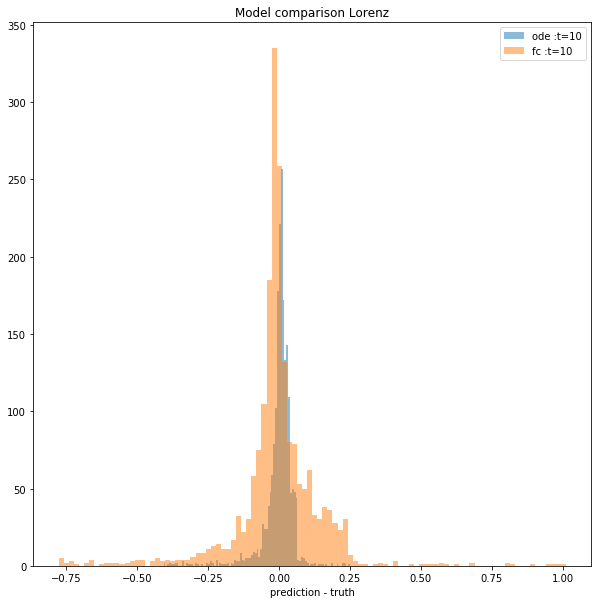

In [151]:
plt.figure(figsize=(10,10))
plt.hist(diff_ode[:,9], label='ode :t=10', alpha = 0.5, bins = 100);
plt.hist(diff_fc[:,9], label='fc :t=10', alpha = 0.5, bins = 100)
plt.title('Model comparison Lorenz')
plt.xlabel('prediction - truth')
plt.savefig('../figure/z_lorenz/z_lorenz_hist.png')
plt.legend()
plt.show()